In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

# Não está bom

In [2]:
start_date = '2014-01-01'

In [3]:
# read and load the csv files
vol_bitfinex_by_supply_btc = pd.read_csv("light_data/vol_bitfinex_by_supply_btc.csv")
total_out_BTC_USD = pd.read_csv("light_data/total_out_BTC_USD.csv")

total_out_BTC_USD.rename(columns={"Unnamed: 0": "Date"}, inplace=True)
vol_bitfinex_by_supply_btc.rename(columns={"Unnamed: 0": "Date"}, inplace=True)

total_out_BTC_USD = total_out_BTC_USD[total_out_BTC_USD["Date"] >= start_date]
vol_bitfinex_by_supply_btc = vol_bitfinex_by_supply_btc[vol_bitfinex_by_supply_btc["Date"] >= start_date]

<Axes: xlabel='Date'>

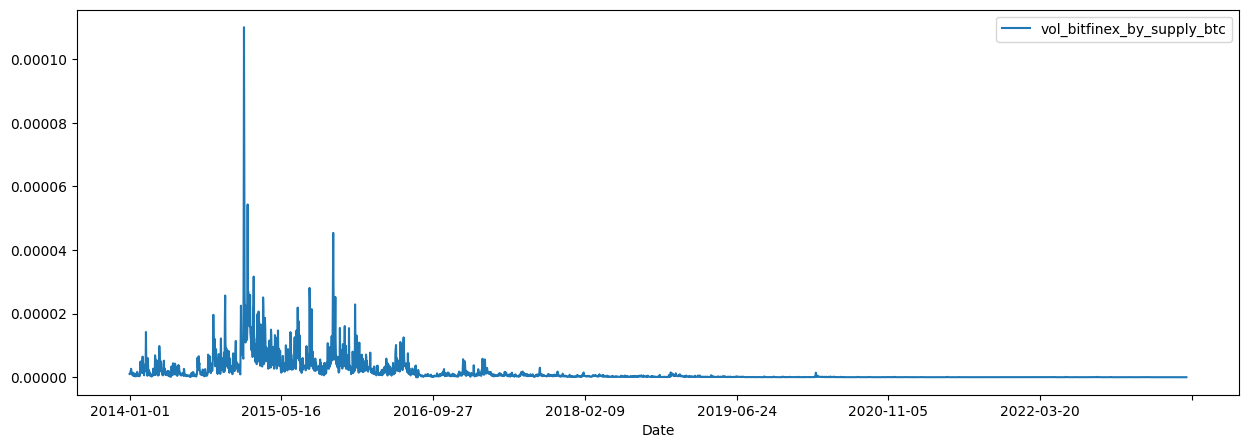

In [4]:
vol_bitfinex_by_supply_btc.plot(x="Date", y="vol_bitfinex_by_supply_btc", figsize=(15, 5))


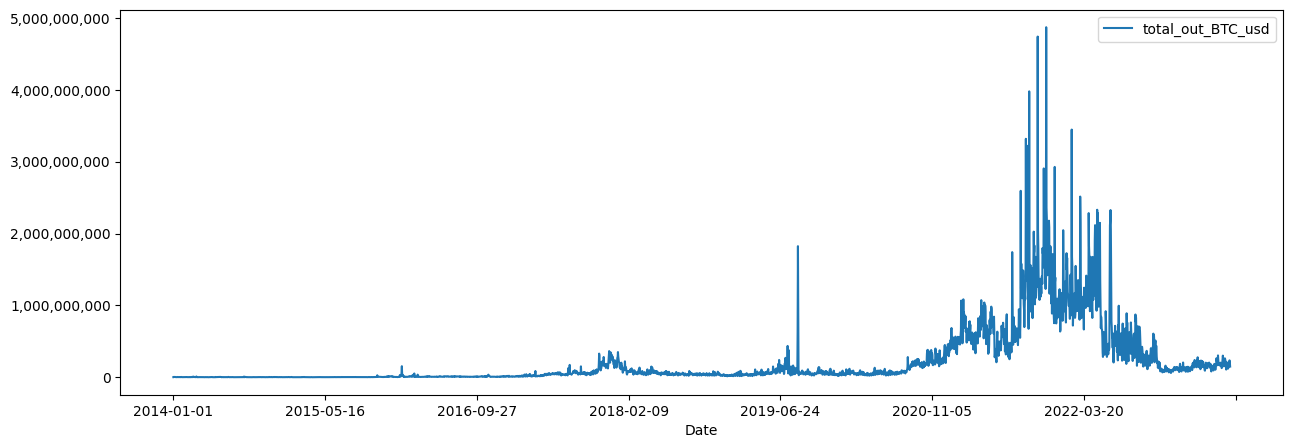

In [5]:
total_out_BTC_USD.plot(x="Date", y="total_out_BTC_usd", figsize=(15, 5))
ax = plt.gca()
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.show()


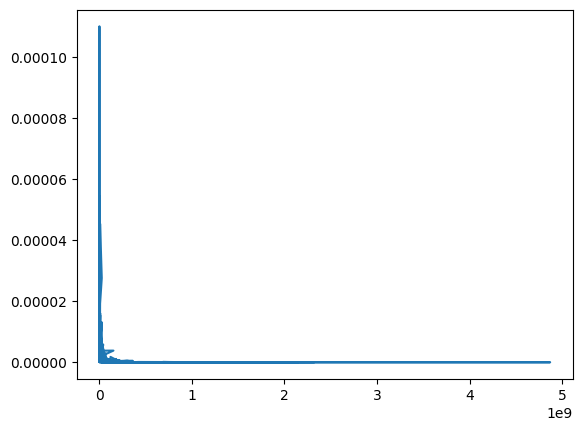

In [24]:
plt.plot(total_out_BTC_USD["total_out_BTC_usd"], vol_bitfinex_by_supply_btc["vol_bitfinex_by_supply_btc"])


# Verify stationarity

In [25]:
def test_stationarity(series):
    result = adfuller(series)
    p_value = result[1]
    
    if p_value <= 0.05:
        print("A série é estacionária.")
    else:
        print("A série não é estacionária.")

test_stationarity(total_out_BTC_USD["total_out_BTC_usd"])
test_stationarity(vol_bitfinex_by_supply_btc["vol_bitfinex_by_supply_btc"])

A série não é estacionária.
A série é estacionária.


# Diff for non stationary series

In [26]:
total_out_BTC_USD["total_out_BTC_usd_diff"] = total_out_BTC_USD["total_out_BTC_usd"].diff()
total_out_BTC_USD = total_out_BTC_USD.dropna() 
test_stationarity(total_out_BTC_USD["total_out_BTC_usd_diff"]) 

A série é estacionária.


In [27]:
# Remove the first row of the dataframe to garantee the same size of the two dataframes
vol_bitfinex_by_supply_btc.iloc[0] = np.nan
vol_bitfinex_by_supply_btc = vol_bitfinex_by_supply_btc.dropna()
vol_bitfinex_by_supply_btc

,Date,vol_bitfinex_by_supply_btc
277,2014-01-02,1.039989e-06
278,2014-01-03,1.064864e-06
279,2014-01-04,1.715207e-06
280,2014-01-05,1.874672e-06
281,2014-01-06,2.650594e-06
...,...,...
3754,2023-07-11,2.776199e-09
3755,2023-07-12,6.164820e-09
3756,2023-07-13,5.070062e-09
3757,2023-07-14,1.085426e-09


In [28]:
total_out_BTC_USD

,Date,total_out_BTC_usd,total_out_BTC_usd_diff
277,2014-01-02,4.279188e+06,2.211638e+06
278,2014-01-03,4.622157e+06,3.429691e+05
279,2014-01-04,4.077104e+06,-5.450527e+05
280,2014-01-05,4.450564e+06,3.734603e+05
281,2014-01-06,4.176299e+06,-2.742659e+05
...,...,...,...
3754,2023-07-11,1.835730e+08,1.943238e+06
3755,2023-07-12,1.975522e+08,1.397913e+07
3756,2023-07-13,2.349778e+08,3.742569e+07
3757,2023-07-14,2.077230e+08,-2.725484e+07


In [29]:
df_var = pd.concat([total_out_BTC_USD["total_out_BTC_usd_diff"], vol_bitfinex_by_supply_btc["vol_bitfinex_by_supply_btc"]],axis=1)
df_var = df_var.set_index(vol_bitfinex_by_supply_btc["Date"]) 
df_var

,total_out_BTC_usd_diff,vol_bitfinex_by_supply_btc
Date,,
2014-01-02,2.211638e+06,1.039989e-06
2014-01-03,3.429691e+05,1.064864e-06
2014-01-04,-5.450527e+05,1.715207e-06
2014-01-05,3.734603e+05,1.874672e-06
2014-01-06,-2.742659e+05,2.650594e-06
...,...,...
2023-07-11,1.943238e+06,2.776199e-09
2023-07-12,1.397913e+07,6.164820e-09
2023-07-13,3.742569e+07,5.070062e-09


# Adjust VAR Model

In [30]:
model = VAR(df_var)
result = model.fit(2)  # 2 é o atraso (número de lags)

print(result.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 10, Nov, 2023
Time:                     19:34:03
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    12.3219
Nobs:                     3480.00    HQIC:                   12.3105
Log likelihood:          -31275.1    FPE:                    220618.
AIC:                      12.3042    Det(Omega_mle):         219985.
--------------------------------------------------------------------
Results for equation total_out_BTC_usd_diff
                                        coefficient            std. error           t-stat            prob
----------------------------------------------------------------------------------------------------------
const                                  47812.475328        3277796.847071            0.015           0.988
L1.total_out_BTC_usd_diff                 -0.3

/home/moises/.pyenv/versions/3.11.3/envs/research_btc/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [31]:
# Fazendo previsões para 2 períodos à frente
forecast = result.forecast(df_var.values, steps=2)

# Exibindo as previsões
print("Previsões:")
print(forecast)

Previsões:
[[2.64179677e+07 3.39420137e-07]
 [7.63401320e+06 6.24267639e-07]]


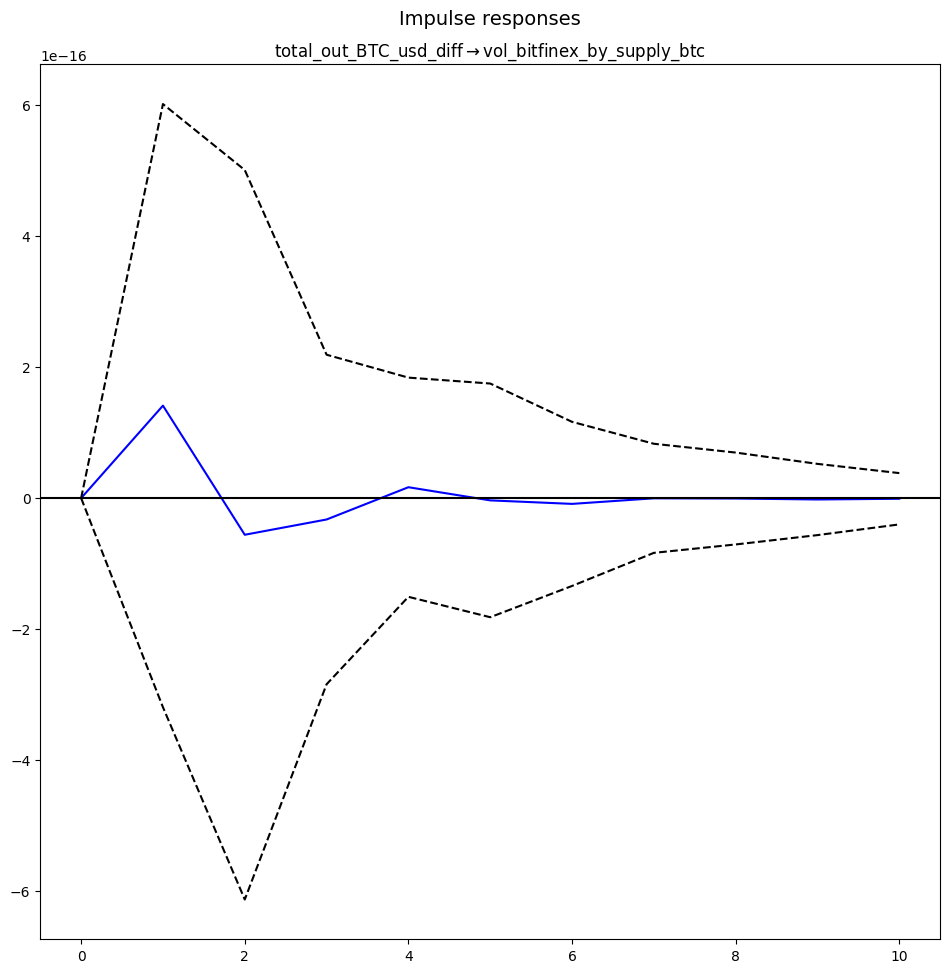

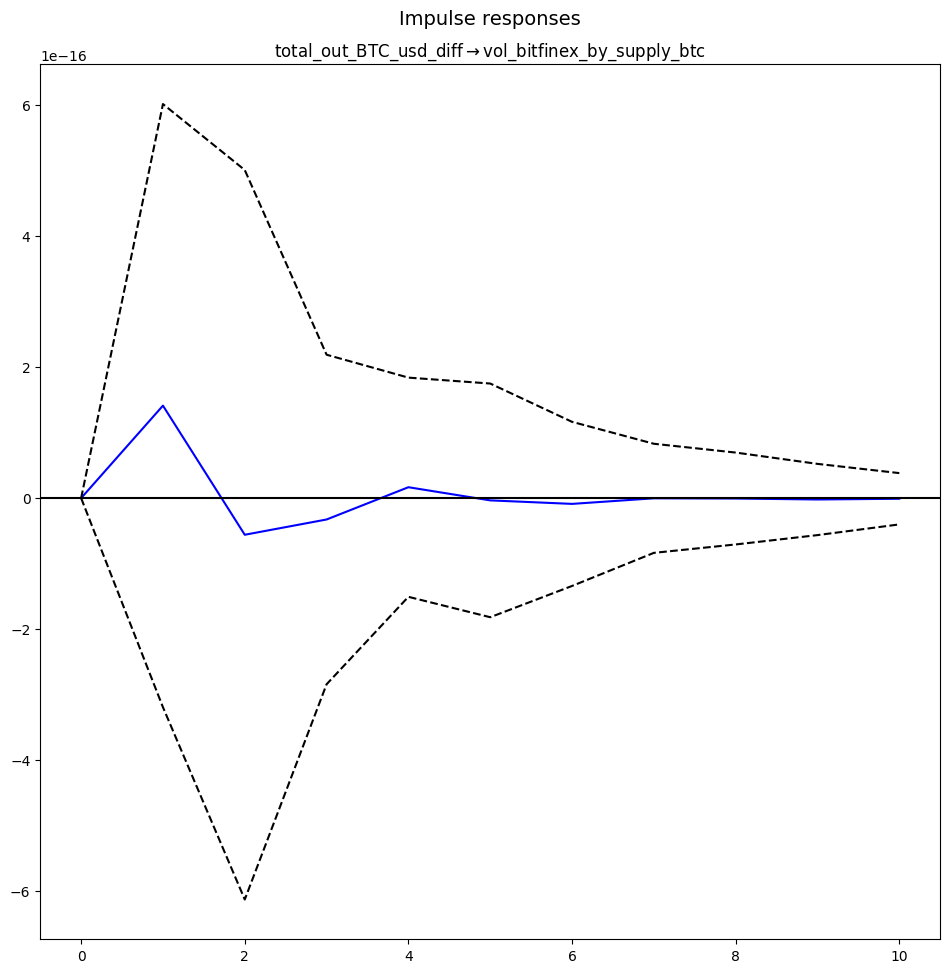

In [32]:
# Analisando o efeito de um choque nas variáveis (por exemplo, um aumento de 10 no PIB)
irf = result.irf(10)
irf.plot(impulse='total_out_BTC_usd_diff', response='vol_bitfinex_by_supply_btc')

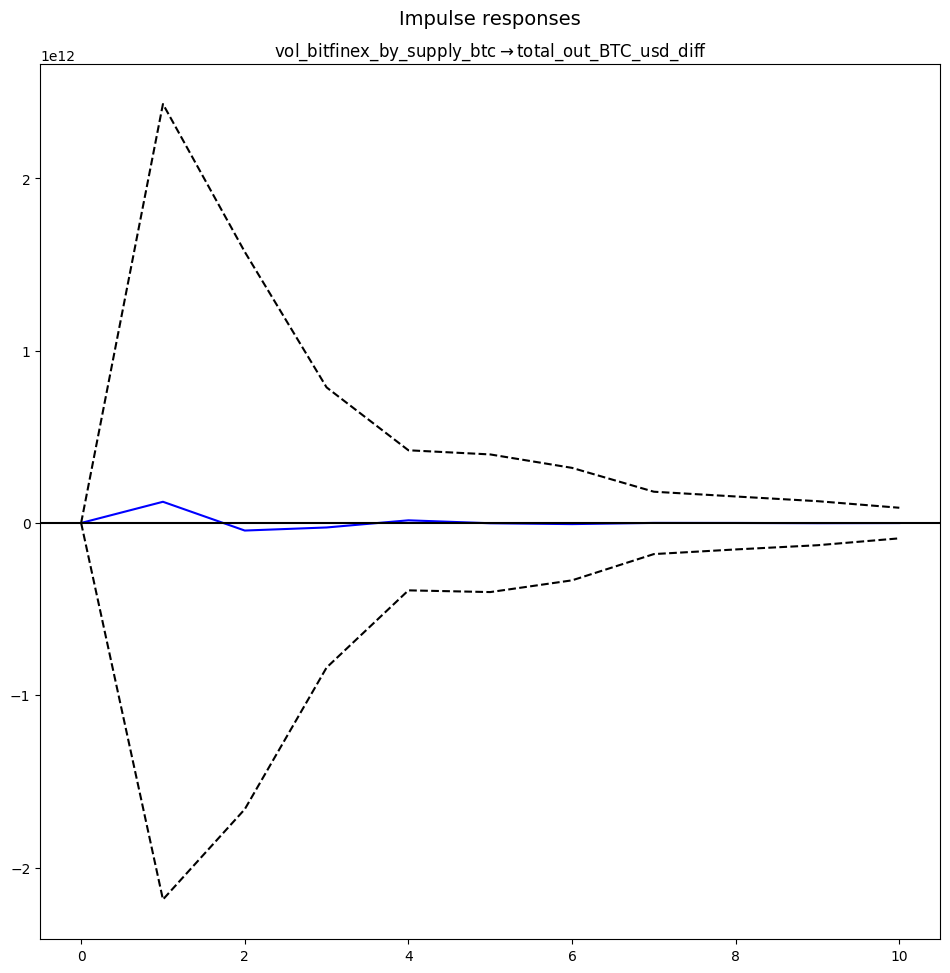

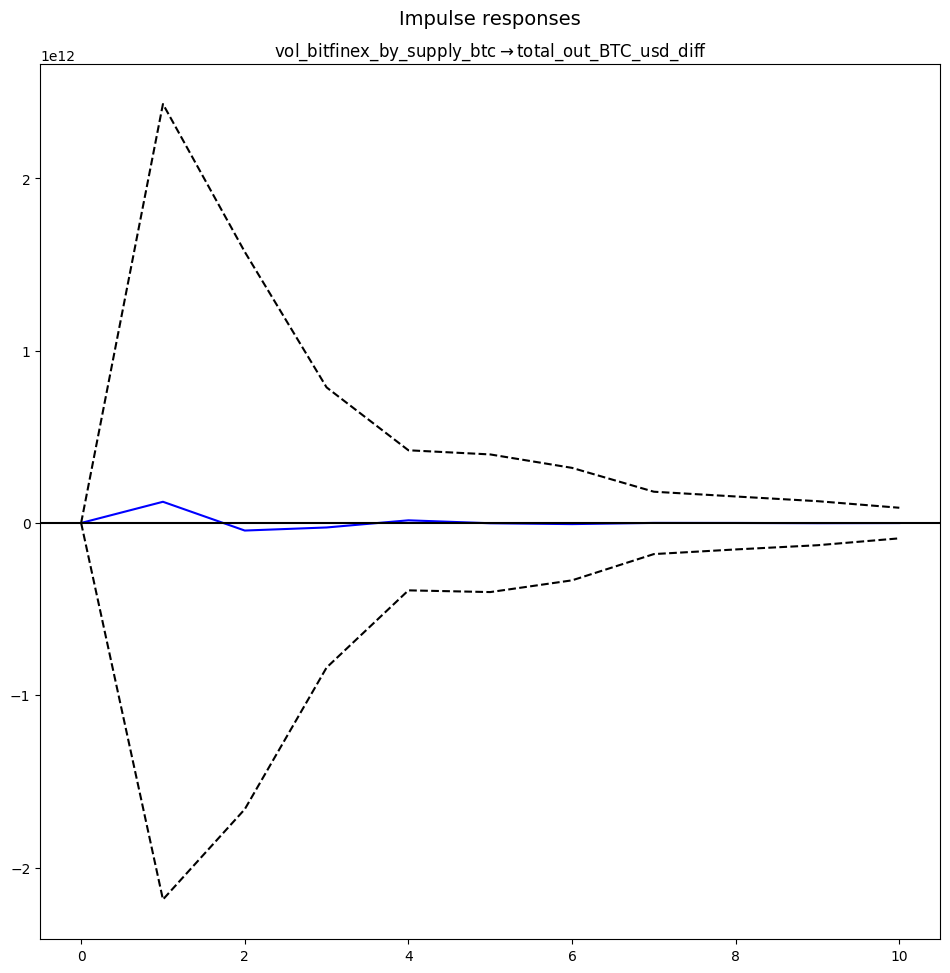

In [33]:
# Analisando o efeito de um choque nas variáveis (por exemplo, um aumento de 10 no PIB)
irf = result.irf(10)
irf.plot(impulse='vol_bitfinex_by_supply_btc', response='total_out_BTC_usd_diff')

In [36]:
from statsmodels.tsa.stattools import grangercausalitytests

max_lag = 60
test_result = grangercausalitytests(df_var[['total_out_BTC_usd_diff','vol_bitfinex_by_supply_btc']], max_lag, verbose=True)

/home/moises/.pyenv/versions/3.11.3/envs/research_btc/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0025  , p=0.9599  , df_denom=3478, df_num=1
ssr based chi2 test:   chi2=0.0025  , p=0.9599  , df=1
likelihood ratio test: chi2=0.0025  , p=0.9599  , df=1
parameter F test:         F=0.0025  , p=0.9599  , df_denom=3478, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0055  , p=0.9945  , df_denom=3475, df_num=2
ssr based chi2 test:   chi2=0.0110  , p=0.9945  , df=2
likelihood ratio test: chi2=0.0110  , p=0.9945  , df=2
parameter F test:         F=0.0055  , p=0.9945  , df_denom=3475, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0035  , p=0.9997  , df_denom=3472, df_num=3
ssr based chi2 test:   chi2=0.0104  , p=0.9997  , df=3
likelihood ratio test: chi2=0.0104  , p=0.9997  , df=3
parameter F test:         F=0.0035  , p=0.9997  , df_denom=3472, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.0030  , p=1.

In [38]:
max_lag = 60
test_result = grangercausalitytests(df_var[['vol_bitfinex_by_supply_btc',"total_out_BTC_usd_diff"]], max_lag, verbose=True)

/home/moises/.pyenv/versions/3.11.3/envs/research_btc/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0000  , p=0.9973  , df_denom=3478, df_num=1
ssr based chi2 test:   chi2=0.0000  , p=0.9973  , df=1
likelihood ratio test: chi2=0.0000  , p=0.9973  , df=1
parameter F test:         F=0.0000  , p=0.9973  , df_denom=3478, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=-0.0525 , p=1.0000  , df_denom=3475, df_num=2
ssr based chi2 test:   chi2=-0.1051 , p=1.0000  , df=2
likelihood ratio test: chi2=-0.1051 , p=1.0000  , df=2
parameter F test:         F=0.0443  , p=0.9567  , df_denom=3475, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=-0.0332 , p=1.0000  , df_denom=3472, df_num=3
ssr based chi2 test:   chi2=-0.0999 , p=1.0000  , df=3
likelihood ratio test: chi2=-0.0999 , p=1.0000  , df=3
parameter F test:         F=0.0258  , p=0.9944  , df_denom=3472, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=-0.0135 , p=1.